# Introduction 

This builds a basic VAMPnets model without the deeptime module. The resulting output will still be put in a deptime VAMP model to compare to the deeptime version. 

In [1]:
from copy import deepcopy
from pathlib import Path
from functools import partial
import pickle as pk


import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from addict import Dict as Adict
import mdshare

from deeptime.util.types import to_dataset
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import vampnet_loss
import seaborn as sns

%reload_ext autoreload
%autoreload 2
from celerity.models import VAMPnetEstimator, VAMPNetModel, HedgeVAMPNetEstimator


### Load data

In [2]:
with np.load(Path('data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz').open('rb')) as fh:
    all_data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

with np.load(Path('data/alanine-dipeptide-3x250ns-backbone-dihedrals.npz')) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

In [3]:
data = all_data

### Configuration

In [4]:
lag_time = 1
validation_split = 0.3
batch_size = 1000

# vampnet estimator config
nn_config = Adict(
      input_dim=data[0].shape[1], 
      output_dim=6,
      n_hidden_layers=2,
      hidden_layer_width=100, 
      loss=partial(vampnet_loss, method='VAMP2', mode='regularize', epsilon=1e-6 ), 
      b=0.98, # beta, expert update rate
      n=3*(5e-3), # eta, learning rate.  
      s=0.1, # mimimum expert weight
      device="cuda",
      batch_size=batch_size
) 

In [5]:
dataset = to_dataset(data=data, lagtime=lag_time)
n_val = int(len(dataset)*validation_split)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 
data_tensors = [torch.Tensor(x) for x  in data]

### Fit and transform

In [6]:
alphas = []
test_scores = []
train_scores = []
test_times = []

record_interval = 10

est = HedgeVAMPNetEstimator(**nn_config)

predictions = []

for i, x in enumerate(loader_train):
    est.train()
    est.partial_fit(x)

    if i % record_interval == 0: 
        # print(f"{i/len(loader_train):2%}")

        alphas.append(est.get_alphas())
        train_scores.append(-est.predict(x))
        tmp = []
        est.eval()
        for val in loader_val: 
            tmp.append(-est.predict(val))
        test_scores.append(np.mean(tmp))
        test_times.append((i+1)*batch_size)



predictions_by_layer  = {0: [], 1: [],  2: [], 3: [], 4: []}
est.eval()
for x in data_tensors:
    y, _ = est.forward((x, x))
    for layer_num in range(est.n_hidden_layers):
        result = y[layer_num].detach().cpu().numpy()

        predictions_by_layer[layer_num].append(result)

tmp = []
for x in data_tensors:
    y = est.transform(x)
    tmp.append(y)
predictions.append(tmp)

In [7]:
pk.dump(file=open('hbp_ave_predictions.pkl', 'wb'), obj=predictions)
pk.dump(file=open('hbp_layer_predictions.pkl', 'wb'), obj=predictions_by_layer)
pk.dump(file=open('hbp_training_scores.pkl', 'wb'), obj=(test_times, test_scores))
pk.dump(file=open('hbp_weights.pkl', 'wb'), obj=list(alphas))

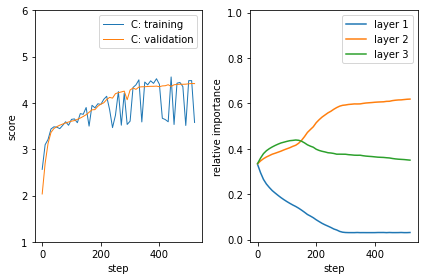

In [8]:
fig, axes = plt.subplots(1, 2)

ax = axes[0]
ax.plot(np.arange(len(test_scores))*record_interval,train_scores, label='C: training',lw=1)

ax.plot(np.arange(len(test_scores))*record_interval, test_scores, label='C: validation',lw=1)
ax.set_xlabel('step')
ax.set_ylabel('score')
# plt.xscale('log')
ax.legend();
ax.set_ylim(1, nn_config.output_dim)

ax = axes[1]
for i in range(est.n_hidden_layers): 
    ax.plot(np.arange(len(test_scores))*record_interval,np.array(alphas)[:, i], label=f'layer {i+1}')
ax.legend()
# plt.xscale('log')
ax.set_xlabel('step')
ax.set_ylabel('relative importance')
ax.set_ylim(-0.01, 1.01)
plt.tight_layout()

### State assigments and timescales

NameError: name 'n_epochs' is not defined

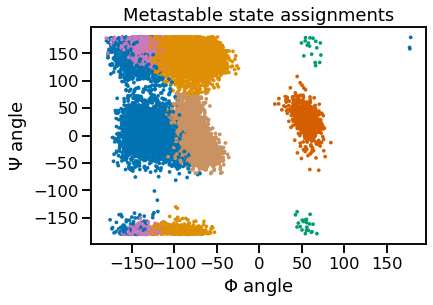

In [9]:
epoch_ix = 0
with sns.plotting_context('talk'):
    assignments = predictions[epoch_ix][0].argmax(1)
    cols = sns.color_palette('colorblind', nn_config.output_dim)

    dihedral_deg = np.rad2deg(dihedral[0])
    dihedral_deg = dihedral_deg[::10, :]
    assignments = assignments[::10]
    state_cols = [cols[i] for i in assignments]

    n_params = np.sum([len(x) for x in list(est.parameters())])
    optimizer = "Hedged-SGD"

    fig, ax = plt.subplots(1)

    ax.scatter(*dihedral_deg.T, c=state_cols, s=5, alpha=1)
    ax.set_title('Metastable state assignments')
    ax.set_xlabel('$\Phi$ angle')
    ax.set_ylabel('$\Psi$ angle')
    plt.savefig(f'figures/ala2_states_{optimizer}_{n_epochs}-epochs_{n_params}-params.pdf', bbox_inches='tight')
# ax.set_title(f'Layer {layer_num+1}');

# fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# for layer_num, ax in enumerate(axes.flatten()):
#     if layer_num < 3:
#         assignments = predictions[epoch_ix][layer_num][0].argmax(1)
#         ax.scatter(*dihedral[0].T, c=assignments, s=5, alpha=.1)
#         ax.set_title(f'Layer {layer_num+1}');

# plt.tight_layout()
    # plt.savefig(f'figures/hedged_output_epoch_{epoch_ix}.png')
    # plt.close()

In [ ]:
n_timescales = 3 

lags = np.arange(1, 100, 1)
timescales = np.empty((n_timescales, len(lags)))
for i, lag_time in enumerate(lags):
    vamp_estimator = VAMP(lagtime=lag_time)
    vamp_estimator.fit_from_timeseries(predictions[epoch_ix])
    vamp_model = vamp_estimator.fetch_model()
    timescales[:, i] = vamp_model.timescales(n_timescales)


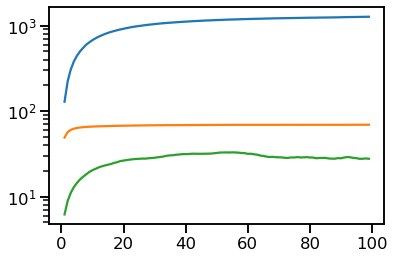

In [ ]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1)
    ax.plot(lags, timescales.T)
    ax.set_yscale('log')
    